# Using BERT to Identify Bill Hardy (Binary Classification)

## Classification of the Pages

[K-means clustering seems to indicate that some narrators can be inferred from the pages](./1_k-means.ipynb). 

To test this hypothesis, supervised learning will be used to classify the pages.

**Bill Hardy**, whose pages where clustered together, is a good candidate for this binary classification.

<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with the label: `True` for Bill Hardy, `False` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def is_bill(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key == "Bill Hardy"
    return None


df = df.astype({"text": "string"})
df["is_Bill"] = df["page"].apply(lambda x: is_bill(x))
df

,page,text,is_Bill
0,1,I sit down alone at the appointed table and ta...,True
1,2,I plunged for the last time. The few remaining...,False
2,3,"At my meeting with Clement yesterday, he had b...",False
3,4,And I really think I would have preferred the ...,True
4,5,I hated my eye for being caught by what didn’t...,False
...,...,...,...
95,96,Now I think I will try a cup of what they inso...,True
96,97,To have slept and to wake right up surrounded ...,False
97,98,He stood and looked down at me; but I was not ...,False
98,99,"And she wore a mauve love-knot on her breast, ...",False


In [4]:
# "modernize" the writing
vocabulary = {
    "to-day": "today",
    "for ever": "forever",
    "any more": "anymore",
    "skilful": "skillful",
    "bell-flower": "bellflower",
    "rain-proof": "rainproof",
    "good-bye": "goodbye",
    "to-night": "tonight",
    "parti-panties": "party-panties",
    "spare-room": "spare room",
    "long seed": "long-seed",
    "finger-tips": "fingertips",
    "market place": "marketplace",
    "match box": "matchbox",
    "spare-room": "spare room",
    "grape vine": "grapevine",
    "gold-leaf": "gold leaf",
    "motor boat": "motorboat",
    "May be": "Maybe",
    "salt-cellar": "salt cellar",
    "every one": "everyone",
}

for old, new in vocabulary.items():
    df["text"] = df["text"].str.replace(old, new)

df

,page,text,is_Bill
0,1,I sit down alone at the appointed table and ta...,True
1,2,I plunged for the last time. The few remaining...,False
2,3,"At my meeting with Clement yesterday, he had b...",False
3,4,And I really think I would have preferred the ...,True
4,5,I hated my eye for being caught by what didn’t...,False
...,...,...,...
95,96,Now I think I will try a cup of what they inso...,True
96,97,To have slept and to wake right up surrounded ...,False
97,98,He stood and looked down at me; but I was not ...,False
98,99,"And she wore a mauve love-knot on her breast, ...",False


Combining the pages and the suggested solution results in a series of numbered pages with a boolean label indicating whether they belong to Bill Hardy. 

The data is now labeled.

## Train BERT Model

BERT (Bidirectional Encoder Representations from Transformers) can  be used to classify the pages.

The goal is to train the model on a subset of the pages belonging to Bill Hardy and pages belonging to one of the other seven narrators.

Empirically, [BERT<sub>BASE</sub> uncased](https://huggingface.co/bert-base-uncased) has appeared suitable for this purpose.

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT large uncased model
# https://huggingface.co/bert-large-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1
)

Experimenting with different hyperparameters indicates a good balance between accuracy and training performance can be achieved with a learning rate of 2 × 10<sup>-5</sup> and 20 learning epochs. 

In [6]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The book is sampled for training and testing in the following proportion:

* **4 Bill Hardy pages**, and
* **25 pages from other narrators**

The size of the test dataset is 20% of the sampled subset of the book.

Therefore, **a little bit less than 30% of the book is used for training and testing**. Lower proportions significantly decrease the accuracy of the model. 

In [7]:
from sklearn.model_selection import train_test_split


def get_datasets(df):
    # sample 40% of the Bill pages/sentences and 25% of all pages/sentences
    df_bill = df[df["is_Bill"] == True].sample(frac=0.3)
    df_not_bill = df[df["is_Bill"] == False].sample(frac=0.28)

    df_sampled = pd.concat([df_bill, df_not_bill], axis=0)

    print(df_sampled)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled["is_Bill"].values,
        test_size=0.2,
        random_state=42,
    )


train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

    page                                               text  is_Bill
3      4  And I really think I would have preferred the ...     True
99   100  I dimly guess why the old dead so wanted this....     True
46    47  Babs now moves across the vision, crowned with...     True
22    23  I hate seeing things like this in the paper. B...     True
31    32  I was a little consoled for the weeping weathe...    False
74    75  I saw to it that I should be for a moment alon...    False
45    46  In one way, of course, I was glad they were ma...    False
21    22  He always talked to me about murder, when we w...    False
49    50  The swallow, the bright Homonoea.I wondered if...    False
26    27  I had seen, day after day, every sunlit or nig...    False
73    74  photographs of young and laughing athletes, la...    False
50    51  As I was not staying, but only passing through...    False
75    76  Looking over at the sly sideways smile which s...    False
82    83  A flower-seller, fed rud

In [8]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }


# important: set a large max_len for the pages
train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer, max_len=256),
    batch_size=3,
    shuffle=True,
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer, max_len=256),
    batch_size=3,
    shuffle=False,
)

The single output layer neuron produces a raw output for training the model (*e.g.*, `-2.0986`, `0.3608`). Therefore, to compute the loss, it must be wrapped (typically with a sigmoid). PyTorch’s `BCEWithLogitsLoss` is used instead as it is *“more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.”* ([source](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html))

In [9]:
from transformers import AdamW
import copy


def train(dataloader):
    model = copy.copy(bert_model)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].squeeze().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits.flatten(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model


model = train(train_dataloader)

1/20 — loss: 0.6541
2/20 — loss: 0.4976
3/20 — loss: 0.4327
4/20 — loss: 0.3693
5/20 — loss: 0.3401
6/20 — loss: 0.2532
7/20 — loss: 0.1665
8/20 — loss: 0.1220
9/20 — loss: 0.0720
10/20 — loss: 0.0469
11/20 — loss: 0.0316
12/20 — loss: 0.0224
13/20 — loss: 0.0160
14/20 — loss: 0.0124
15/20 — loss: 0.0108
16/20 — loss: 0.0092
17/20 — loss: 0.0088
18/20 — loss: 0.0077
19/20 — loss: 0.0070
20/20 — loss: 0.0061


## Prediction

In [10]:
from sklearn.metrics import accuracy_score


def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int)

    return predicted_labels

In [11]:
predictions = eval(model, test_texts)
accuracy = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 1.0000


The model's accuracy is acceptable (typically between 90% and 100%). Consequently, the labels can be predicted for *all* book pages (`df.text.values`).

In [12]:
predicted_labels = eval(model, df.text.values)

<Figure size 800x600 with 0 Axes>

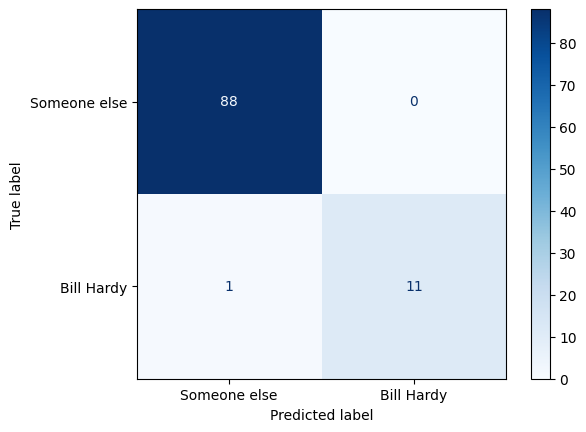

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def generate_confusion_matrix(model, df, predicted_labels):
    cm = confusion_matrix(df.is_Bill.values, predicted_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Someone else", "Bill Hardy"]
    )

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")

    plt.show()


generate_confusion_matrix(model, df, predicted_labels)

The confusion matrix reveals that the model performs well with page as inputs. It can reliably predict when a page belongs to Bill Hardy or not.

The model is not perfect (notably because of the limited data and its goal) and makes erroneous predictions from time to time.

In [14]:
def identify_misclassified_items(df, predicted_labels, item_type):
    misclassified_indices = [
        i
        for i, (true, pred) in enumerate(zip(df.is_Bill.values, predicted_labels))
        if true != pred
    ]

    if len(misclassified_indices) == 0:
        print(f"No misclassified {item_type}\n")
        return

    print(f"Misclassified {item_type}:")
    for index in misclassified_indices:
        print(
            f"Expected narrator: {int(df.is_Bill.values[index])} — predicted narrator: {predicted_labels[index][0]} — [{df.page.values[index]}] {df.text.values[index]}"
        )


identify_misclassified_items(df, predicted_labels, "pages")

Misclassified pages:
Expected narrator: 1 — predicted narrator: 0 — [96] Now I think I will try a cup of what they insolently call Golden Tips, a find young Tippy Tea. And then they say specifically No Tips. It is very disheartening. While I am waiting for it, and for the possible her, I study the only literature before me. What is a Loganberry Kiss? Is it at all like the Plover’s Lunch, that hurts and is desired? It is strange to think that Catharine is even at this moment turning a Somerset in front of the altar. The whole business reminds me of the time we lay outside Jifjaffa, and the Padre said to me: “I would rather have written that poem than take castor oil in the morning.” I had been reading him my Ode on the Intimations of Immorality in Early Childhood. Well, well. How vividly, whenever I adventure on stew now, I remember the stew we had that night. How it all comes back. The whole circumstances of this meeting are so mysterious. It gars me grue, if I may be permitted the exp

# Predicted Pages Representation

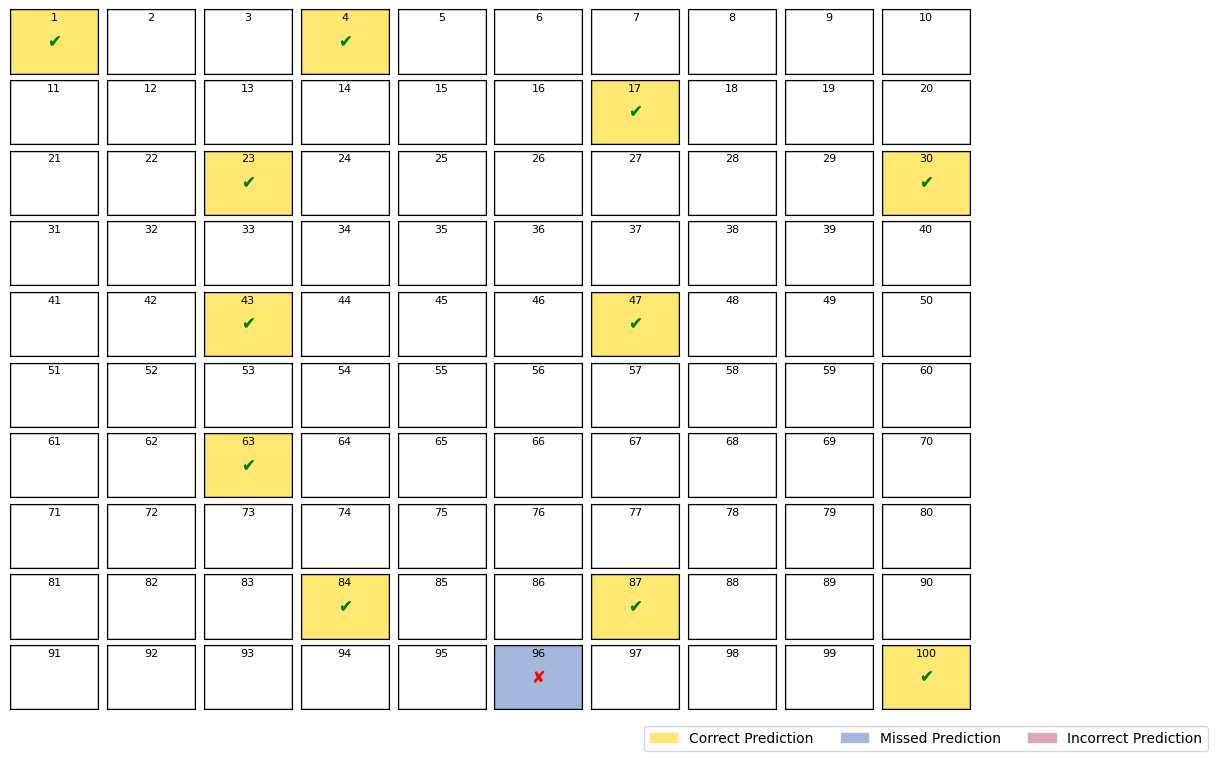

In [15]:
import matplotlib.patches as mpatches

cols, rows = 10, 10

expected_pages = [page - 1 for page in df[df["is_Bill"]]["page"].values.tolist()]
predicted_pages = [
    index for index, value in enumerate(predicted_labels.flatten()) if value == 1
]

fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), tight_layout=True)

for i, ax in enumerate(axs.ravel()):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.add_patch(
        plt.Rectangle((0, 0), 1, 1, fill=True, edgecolor="#000000", facecolor="#FFFFFF")
    )
    row, col = divmod(i, cols)
    ax.text(0.5, 0.95, str(i + 1), ha="center", va="top", color="#000000", fontsize=8)

common_indices = set.intersection(set(expected_pages), set(predicted_pages))

for index in expected_pages + predicted_pages:
    row, col = divmod(index, cols)

    if index in common_indices:
        # pages adequately predicted
        axs[row, col].patches[0].set_facecolor("#FFE871")
        axs[row, col].text(
            0.5, 0.5, "✔", ha="center", va="center", color="green", fontsize=12
        )
    elif index in expected_pages:
        # pages erroneously not predicted
        axs[row, col].patches[0].set_facecolor("#A6B7DE")
        axs[row, col].text(
            0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
        )
    else:
        # pages erroneously predicted
        axs[row, col].patches[0].set_facecolor("#DEA6BA")
        axs[row, col].text(
            0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
        )

plt.legend(
    handles=[
        mpatches.Patch(color="#FFE871", label="Correct Prediction"),
        mpatches.Patch(color="#A6B7DE", label="Missed Prediction"),
        mpatches.Patch(color="#DEA6BA", label="Incorrect Prediction"),
    ],
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    ncol=3,
)

fig.set_size_inches(12, 10)
plt.subplots_adjust(top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.1, wspace=0.1)

plt.show()

***

## Classification of the Sentences

This approach can be transposed to the classification of sentences. It suffices to tokenize the pages.

In [16]:
# tokenize pages
from nltk import sent_tokenize


def tokenize_sentences(paragraph):
    sentences = sent_tokenize(paragraph)

    valid_sentences = [
        sentence for sentence in sentences if any(c.isalnum() for c in sentence)
    ]
    return valid_sentences


df["text"] = df["text"].apply(tokenize_sentences)
df = df.explode("text").reset_index(drop=True)
df

,page,text,is_Bill
0,1,I sit down alone at the appointed table and ta...,True
1,1,"Call me nervous, call me fey, if you will; at ...",True
2,1,It has not had much work since it flew so nimb...,True
3,1,"As I watch the sea, Casy Ferris passes with do...",True
4,1,"Of course, today is the day.",True
...,...,...,...
1226,100,O beastly woman.,True
1227,100,"You know not how ill’s all here, about my hear...",True
1228,100,"Henry, I feel it, is for the first and last ti...",True
1229,100,"Good-bye, Henry.",True


In [17]:
train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer), batch_size=20, shuffle=True
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer), batch_size=20, shuffle=False
)

      page                                               text  is_Bill
759     63         But I have called them all by their names.     True
205     17   Why should I think her beauty somewhat sinister?     True
284     23  The thought of that evening in the Left Luggag...     True
378     30                                             Sorry.     True
1055    87  Is she, or is she not, a little pale about the...     True
...    ...                                                ...      ...
147     13  Just like that sort of a poet, I supposed they...    False
173     15  And my namesake wrote a letter, in which he sa...    False
989     82          He was the third dog I had had in London.    False
1116    92             My earlier days had been so different.    False
114     10  If he got the third point, she’d owe him a box...    False

[348 rows x 3 columns]
Train dataset size: 278
Test dataset size: 70


In [18]:
model = train(train_dataloader)

1/20 — loss: 0.2432
2/20 — loss: 0.1087
3/20 — loss: 0.0580
4/20 — loss: 0.0263
5/20 — loss: 0.0134
6/20 — loss: 0.0090
7/20 — loss: 0.0065
8/20 — loss: 0.0050
9/20 — loss: 0.0045
10/20 — loss: 0.0038
11/20 — loss: 0.0032
12/20 — loss: 0.0024
13/20 — loss: 0.0022
14/20 — loss: 0.0019
15/20 — loss: 0.0017
16/20 — loss: 0.0013
17/20 — loss: 0.0012
18/20 — loss: 0.0012
19/20 — loss: 0.0010
20/20 — loss: 0.0009


In [19]:
predictions = eval(model, test_texts)

accuracy = accuracy_score(test_labels, predictions)
print(f"Test accuracy: {accuracy:.4f}")

Test accuracy: 0.9286


The accuracy is undeniably lower than when the model was trained on pages. This is expected, as isolated sentences may be featureless and mundane,  expressible by anyone.

In [20]:
predicted_labels = eval(model, df.text.values)

<Figure size 800x600 with 0 Axes>

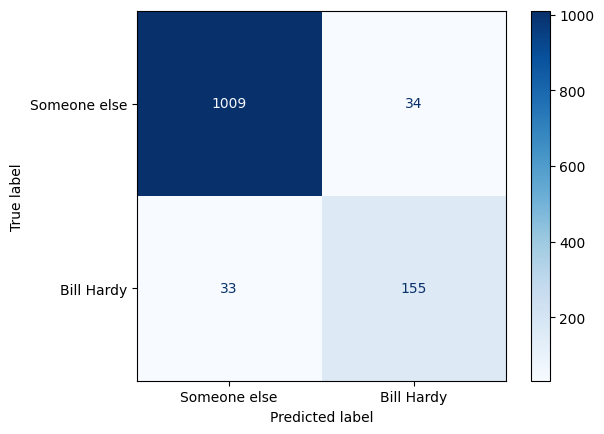

In [21]:
generate_confusion_matrix(model, df, predicted_labels)

In [22]:
identify_misclassified_items(df, predicted_labels, "sentences")

Misclassified sentences:
Expected narrator: 1 — predicted narrator: 0 — [1] But all the nice gulls love a sailor.
Expected narrator: 0 — predicted narrator: 1 — [3] No friend of mine takes his ease in my chair.
Expected narrator: 1 — predicted narrator: 0 — [4] But the queen can do no wrong.
Expected narrator: 1 — predicted narrator: 0 — [4] I remember clearly, perhaps because I ought to have my wits about me for another purpose, how Sir Roland’s father, Sir Weedon, once saw Henry taking the part of Lesurques and mixed him up with Le Cirque d’Hiver.
Expected narrator: 1 — predicted narrator: 0 — [4] If she had said a mashie.
Expected narrator: 0 — predicted narrator: 1 — [6] Why not?
Expected narrator: 0 — predicted narrator: 1 — [13]     Rintrah, where has thou hid thy bride?
Expected narrator: 0 — predicted narrator: 1 — [13] Alas!
Expected narrator: 1 — predicted narrator: 0 — [17] Conveniently situated for some things, that is.
Expected narrator: 1 — predicted narrator: 0 — [17] Or

Examples of sentences typically misclassified: 

* *Oh, yeah.* (May Doncaster)
* *I have no chair.* (John Walker, quoting Walt Whitman)
* *Bill to Solve the Traffic Problem.* (Not attributed to Bill Hardy)
* *O toison, moutonnant jusque sur l’encolure!* (Not attributed to Bill Hardy, quoting Charles Baudelaire)